In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf
import imutils
import nibabel as nib
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib

from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from keras.layers.convolutional import Deconv2D as Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy

In [2]:
df = pd.read_csv('./metadata.csv')

In [3]:
df.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [4]:
img_size = 224
def cropper(img):

    img = np.uint8(img*255)   
    # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]  
    x = np.argsort(areas)   
    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]   
      
    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)
    
    a=min(x,p)
    b=min(y,q)
    c=max(x+w,p+r)
    d=max(y+h,q+s)
    
    cropped= img[b:d, a:c]
    cropped = cv2.resize(cropped, dsize=(250,250), interpolation=cv2.INTER_AREA)
    
    points_lungs = []
    
    points_lungs.append(a); points_lungs.append(b); points_lungs.append(c); points_lungs.append(d)
    
    
    return(cropped, points_lungs)

In [5]:
def clahe_enhancer(img):
    xma=img.max()
    xmi=img.min()
    img=(img-xmi)/(xma-xmi)
    img = np.uint8(img*225)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    return clahe_img

In [6]:
all_points = []


def read_nii(filepath, data, string):
    
    global all_points
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))

    if string == "lungs":
        all_points = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
            continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
            img[img>0]=1
            img, points= cropper(img)
            all_points.append((points[0], points[1], points[2], points[3]))
            continue 

        if string == "cts" and img_no < len(all_points):
            img = clahe_enhancer(img)   
            a,b,c,d = all_points[img_no]
            img1 = img[b:d, a:c]
            img = cv2.resize(img1, dsize=(250,250), interpolation=cv2.INTER_AREA)
            

        if string == "infections" and img_no < len(all_points):
            a,b,c,d = all_points[img_no]
            img = np.uint8(img*255)
            img1 = img[b:d, a:c]
            img = cv2.resize(img1, dsize=(250,250), interpolation=cv2.INTER_AREA)
            
        img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
        data.append(img)

In [7]:
cts = []
lungs = []
infections = []
for i in range(0, 20):
    read_nii(df.loc[i,'lung_mask'],lungs,"lungs")
    read_nii(df.loc[i,'ct_scan'],cts,"cts")
    read_nii(df.loc[i,'infection_mask'],infections,"infections")


<ipython-input-6-3ffcf4256310>:22: RuntimeWarning: invalid value encountered in true_divide
  img = (img - xmin)/(xmax - xmin)


In [8]:
blank_infections = []
for i in range(0, len(infections)):
    if np.unique(infections[i]).size == 1:
        blank_infections.append(i)
print("Number of complete black masks :" , len(blank_infections))



Number of complete black masks : 497


In [9]:
for index in sorted(blank_infections, reverse = True):  
    del infections[index]  
    del cts[index]

In [10]:
nan_list = []
for img_id in range(len(infections)):
    if np.isnan(infections[img_id].sum()):
        nan_list.append(img_id)
for i in nan_list:
    del infections[i]
    del cts[i]
    



In [11]:
len(cts)

1614

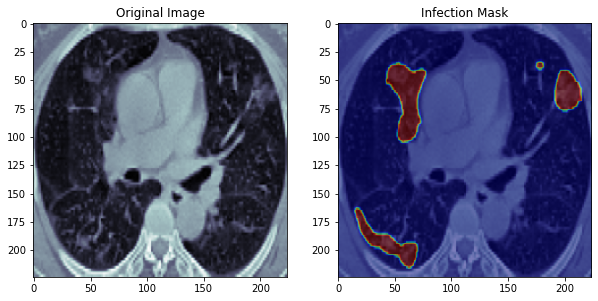

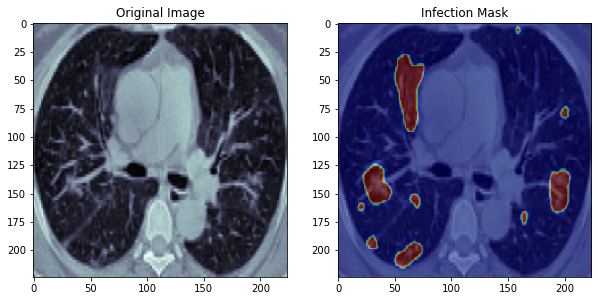

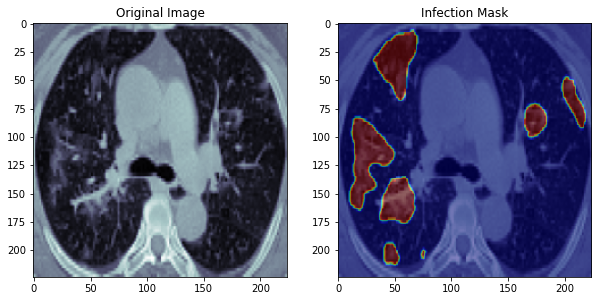

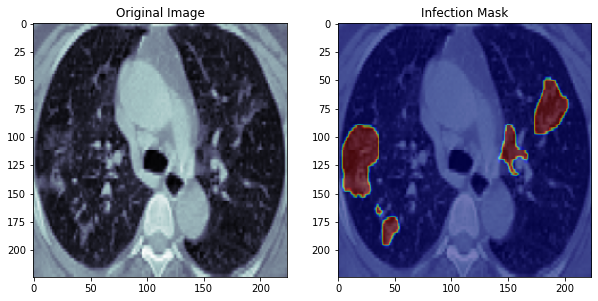

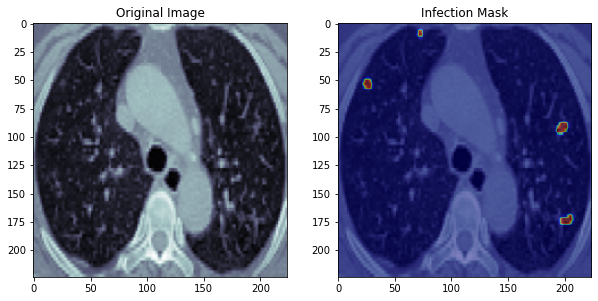

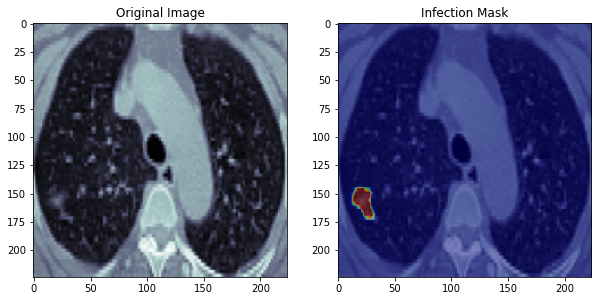

In [12]:

   def plot_sample(array_list, color_map = 'jet'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.imshow(array_list[1].reshape(224, 224), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.show()

for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])

In [13]:
def build_infection_model(input_layer, start_neurons, DropoutRatio = 0.25):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = BatchNormalization()(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = BatchNormalization()(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = BatchNormalization()(uconv2)
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = BatchNormalization()(uconv1)
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    
    output_layer = Conv2D(1, (1,1), activation="sigmoid")(uconv1)
    
    return output_layer

In [14]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss



In [15]:
import math
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.0003, eta_min=0.00003)



In [16]:
cts = np.array(cts)
infections = np.array(infections)

print(cts.shape, infections.shape)
cts = cts/255.
infections = infections/255.

x_train, x_valid, y_train, y_valid = train_test_split(cts, infections, test_size=0.2, random_state=42)
print(x_train.shape, x_valid.shape)

epochs = 50
batch_size = 32

inputs = Input((img_size, img_size, 1))
output_layer = build_infection_model(inputs, 32, 0.25)

checkpointer = ModelCheckpoint(filepath = 'best_infections_224_res.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-5), loss=bce_dice_loss, metrics=[dice_coef])

results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),callbacks=[checkpointer,cosine_annealer])

(1614, 224, 224) (1614, 224, 224)
(1291, 224, 224) (323, 224, 224)
Epoch 1/50

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.0003.
41/41 [==============================] - 1414s 34s/step - loss: 0.5354 - dice_coef: 0.2214 - val_loss: 0.7526 - val_dice_coef: 0.0025

Epoch 00001: val_dice_coef improved from -inf to 0.00253, saving model to best_infections_224_res.h5
Epoch 2/50

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.00028663079716682654.
41/41 [==============================] - 1356s 33s/step - loss: 0.2637 - dice_coef: 0.6049 - val_loss: 0.7238 - val_dice_coef: 0.0025

Epoch 00002: val_dice_coef did not improve from 0.00253
Epoch 3/50

Epoch 00003: CosineAnnealingScheduler setting learning rate to 0.000249171123250929.
41/41 [==============================] - 1169s 28s/step - loss: 0.1960 - dice_coef: 0.7082 - val_loss: 0.7384 - val_dice_coef: 0.0017

Epoch 00003: val_dice_coef did not improve from 0.00253
Epoch 4/50

Epoch 00004: CosineAnnea

41/41 [==============================] - 1094s 27s/step - loss: 0.0955 - dice_coef: 0.8561 - val_loss: 0.1094 - val_dice_coef: 0.8470

Epoch 00027: val_dice_coef improved from 0.84047 to 0.84699, saving model to best_infections_224_res.h5
Epoch 28/50

Epoch 00028: CosineAnnealingScheduler setting learning rate to 0.00028663079716682654.
41/41 [==============================] - 1089s 27s/step - loss: 0.0893 - dice_coef: 0.8672 - val_loss: 0.1108 - val_dice_coef: 0.8472

Epoch 00028: val_dice_coef improved from 0.84699 to 0.84716, saving model to best_infections_224_res.h5
Epoch 29/50

Epoch 00029: CosineAnnealingScheduler setting learning rate to 0.0003.
41/41 [==============================] - 1090s 27s/step - loss: 0.0872 - dice_coef: 0.8703 - val_loss: 0.1167 - val_dice_coef: 0.8342

Epoch 00029: val_dice_coef did not improve from 0.84716
Epoch 30/50

Epoch 00030: CosineAnnealingScheduler setting learning rate to 0.0002866307971668266.
41/41 [==============================] - 1096s 2

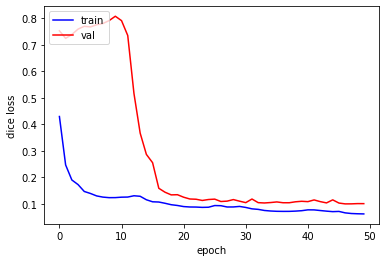

In [25]:
fig, loss_ax = plt.subplots()

loss_ax.plot(results.history['loss'], 'b', label='train')
loss_ax.plot(results.history['val_loss'], 'r', label='val')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('dice loss')


loss_ax.legend(loc='upper left')


plt.show()


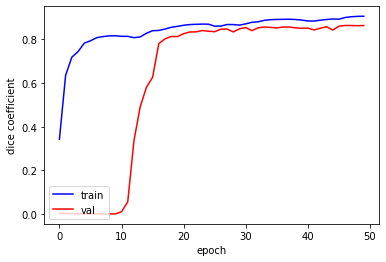

In [26]:
fig, acc_ax = plt.subplots()

acc_ax.plot(results.history['dice_coef'], 'b', label='train')
acc_ax.plot(results.history['val_dice_coef'], 'r', label='val')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('dice coefficient')

acc_ax.legend(loc='lower left')

plt.show()

In [23]:
def compare_actual_and_predicted(image_no):
    
    temp = model.predict(x_valid[image_no].reshape(1,img_size, img_size, 1))

    fig = plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.imshow(x_valid[image_no].reshape(img_size, img_size), cmap='bone')
    plt.axis("off")
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(y_valid[image_no].reshape(img_size,img_size), cmap='bone')
    plt.axis("off")
    plt.title('True mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(img_size,img_size), cmap='bone')
    plt.axis("off")
    plt.title('Predicted mask')

    plt.show()


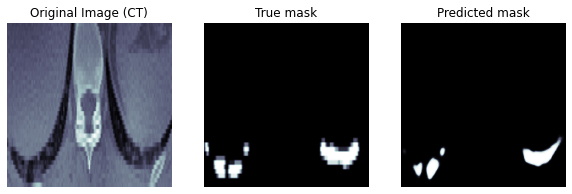

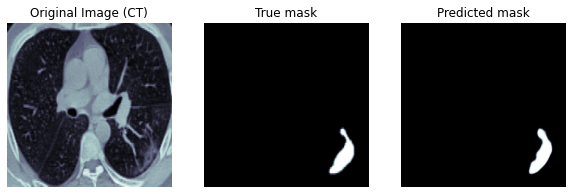

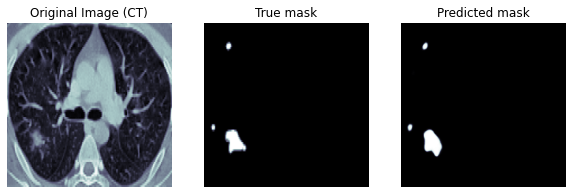

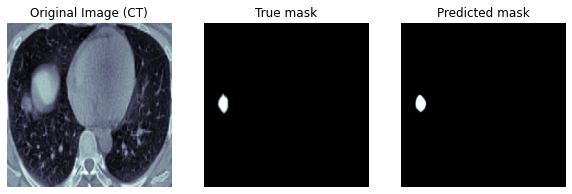

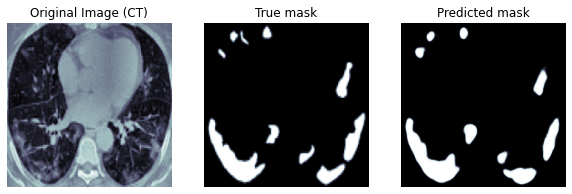

In [24]:
rand = np.random.randint(0, len(x_valid), size=5)
for i in rand:
    compare_actual_and_predicted(i)